# 2- Time-series Signal Metrics  

This file to be executed second

Haytham Mohamed - INFS890 - Spring 2020

Using metrics as time-series data to predict future latency. The data collected from prometheus metrics output directly. Treated as raw observations signals from the application without apply transformation rules processing.

In [415]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:.2f}'.format

In [416]:
home_dir = '/Users/hmohamed/github/data-research-spring2020'

input_dir = home_dir + '/raw-data-linode-run3/merged/'  # this is prepared raw metrics signals
input_file = 'all_data.csv'

output_dir = input_dir                 # output dir for raw signal metrics data
output_file = 'raw_timeseries_data.csv'

target = 'service_ltcy_200'

features = ['service_cpu_use'
            , 'service_memory_use'
            , 'service_cpu_sat'
            , 'service_net_usage'
            , 'service_disk_usage'
            , 'service_req_total'
            , 'service_errors'
            , 'service_request_size'
            , 'service_response_size'
            , 'containers_count'
            , 'system_cpu_usage'
            , 'system_network_usage'
           ]

TARGET_DIFF=False
FEATURES_DIFF=False

TARGET_RATE=False
FEATURES_RATE=False

TARGET_PERCENTILE=False

resample_time_window='S'

rate_time_window = '1T'  # S for second , T for minute
skip = 1 * 60

latency_percentile = 0.95

SAVE=False


In [417]:
data_df = pd.read_csv(input_dir + input_file, header=None, skiprows=1, names=['date', 'value', 'metric'])
data_df.head(5)


,date,value,metric
0,2020-02-27 22:49:53,3504.83,service_cpu_use
1,2020-02-27 22:49:54,5742.95,service_cpu_use
2,2020-02-27 22:49:55,7981.07,service_cpu_use
3,2020-02-27 22:49:56,10242.46,service_cpu_use
4,2020-02-27 22:49:57,11901.57,service_cpu_use


In [418]:
data_df.shape

(1073721, 3)

In [419]:
def extractMetricSeries(df, name):
    metric = df.loc[df['metric'] == name].drop(['metric'], axis=1).rename(index=str, columns={"value": name})
    metric.date = pd.to_datetime(metric.date)
    metric[name] = pd.to_numeric(metric[name])
    metric.set_index('date', inplace=True)
    metric.sort_index()
    return metric

# T for minutes, S for seconds
def resample(df, frequency = resample_time_window, interpolate = True, interpolate_method = 'linear', base=6):
    # fill in missing interval (upsample)
    resampled = df.resample(frequency, kind='timestamp', base=base).bfill()
    if interpolate:
        resampled = resampled.interpolate(method=interpolate_method)
    resampled.sort_index()
    return resampled

def plot_series(df):
    df.plot(figsize=(20,10), linewidth=2, fontsize=20)
    plt.xlabel('Time', fontsize=20);
    plt.show()
    
def diff_series(df):
    # eliminate seasonality, taking first diff
    return df.diff()[1:]       

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).bfill()    
    
def clear_null(df):
    return df[df[target].notna()]  

def eliminate_zeros(df, col):
    return df[df[col] > 0.00]

# df is a timeseries and resampled per second
# window in a form of nS or nT  or nH , where n is an interger (S for seconds, T for minutes, H for hours)
def rate(df, col, interval='S'):    
    #df = df.resample('S', kind='timestamp', base=6).bfill()
    df[col] = df.pct_change(fill_method='ffill', freq=interval)  # change per second
    #df = df.resample(interval, kind='timestamp', base=6).mean()
    df = df.dropna(axis=0, subset=[col])    
    return df
    
def rate_series(df, interval):
    metric = df.metric[0]
    df = df.drop('metric', 1)
    df = rate(df, 'value', interval)
    df['metric'] = metric

# Target  Latency 

In [420]:
print("Processing metric: %", target)
target_df = extractMetricSeries(data_df, target)

nulls = target_df.isnull().sum()
target_df.head(3)

Processing metric: % service_ltcy_200


,service_ltcy_200
date,
2020-02-27 22:49:53,2.53
2020-02-27 22:49:54,2.70
2020-02-27 22:49:55,2.87


In [421]:

target_df = resample(target_df, interpolate=False) 
target_df.shape

(78841, 1)

In [422]:
# check number of nulls
nulls = target_df.isnull().sum()
nulls

service_ltcy_200    0
dtype: int64

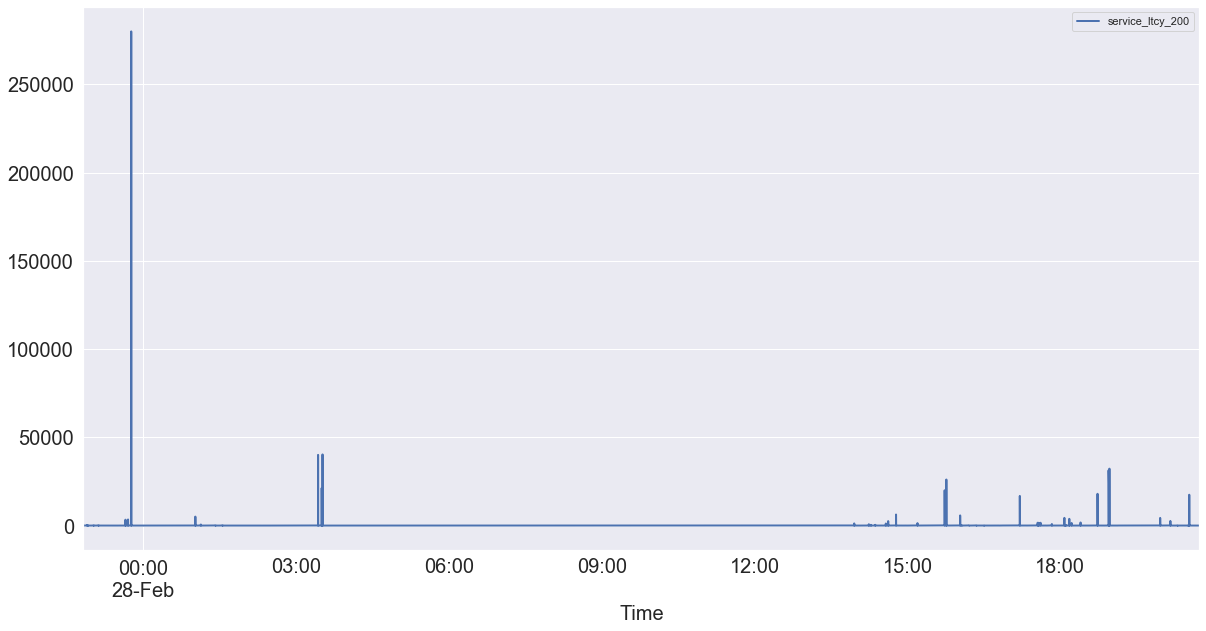

In [423]:
plot_series(target_df)

 ## Latency transformation

In [424]:
# convert latency to percentile of rate change
if TARGET_RATE:
    target_df = target_df.pct_change(fill_method='bfill', freq=rate_time_window)
    target_df = target_df[skip:]   

if TARGET_DIFF:
    target_diff = target_df.diff() 
    target_df = target_df[1:]

if TARGET_PERCENTILE:
    target_df = target_df.groupby(['date']).quantile(latency_percentile)
    target_df = target_df[1:]
        
#target_df = target_df.diff()  
#target_df = target_df[1:]
target_df.sort_index() 
target_df.head(3)

,service_ltcy_200
date,
2020-02-27 22:49:53,2.53
2020-02-27 22:49:54,2.70
2020-02-27 22:49:55,2.87


In [425]:
# check number of nulls
nulls = target_df.isnull().sum()
nulls

service_ltcy_200    0
dtype: int64

In [426]:
# check zero values
nulls = target_df[target_df[target] == 0].sum()
nulls

service_ltcy_200   0.00
dtype: float64

In [427]:
target_df.shape

(78841, 1)

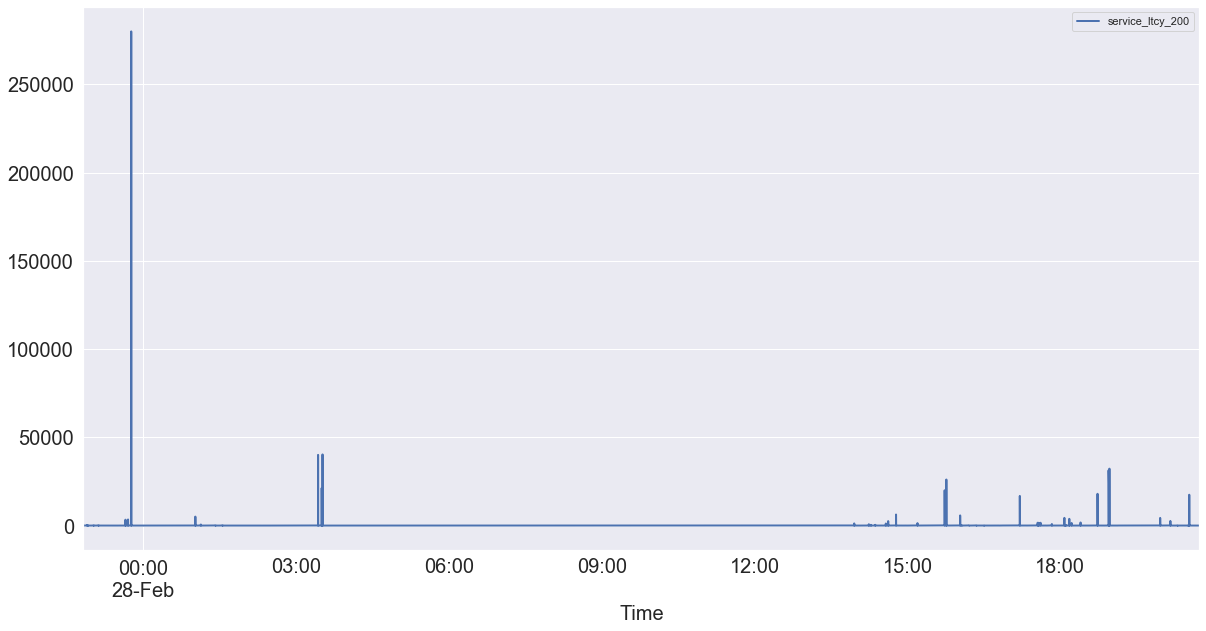

In [428]:
plot_series(target_df)

# Features: 

Processing metric: % service_cpu_use
Processing metric: % service_memory_use
Processing metric: % service_cpu_sat
Processing metric: % service_net_usage
Processing metric: % service_disk_usage
Processing metric: % service_req_total
Processing metric: % service_errors
Processing metric: % service_request_size
Processing metric: % service_response_size
Processing metric: % containers_count
Processing metric: % system_cpu_usage
Processing metric: % system_network_usage


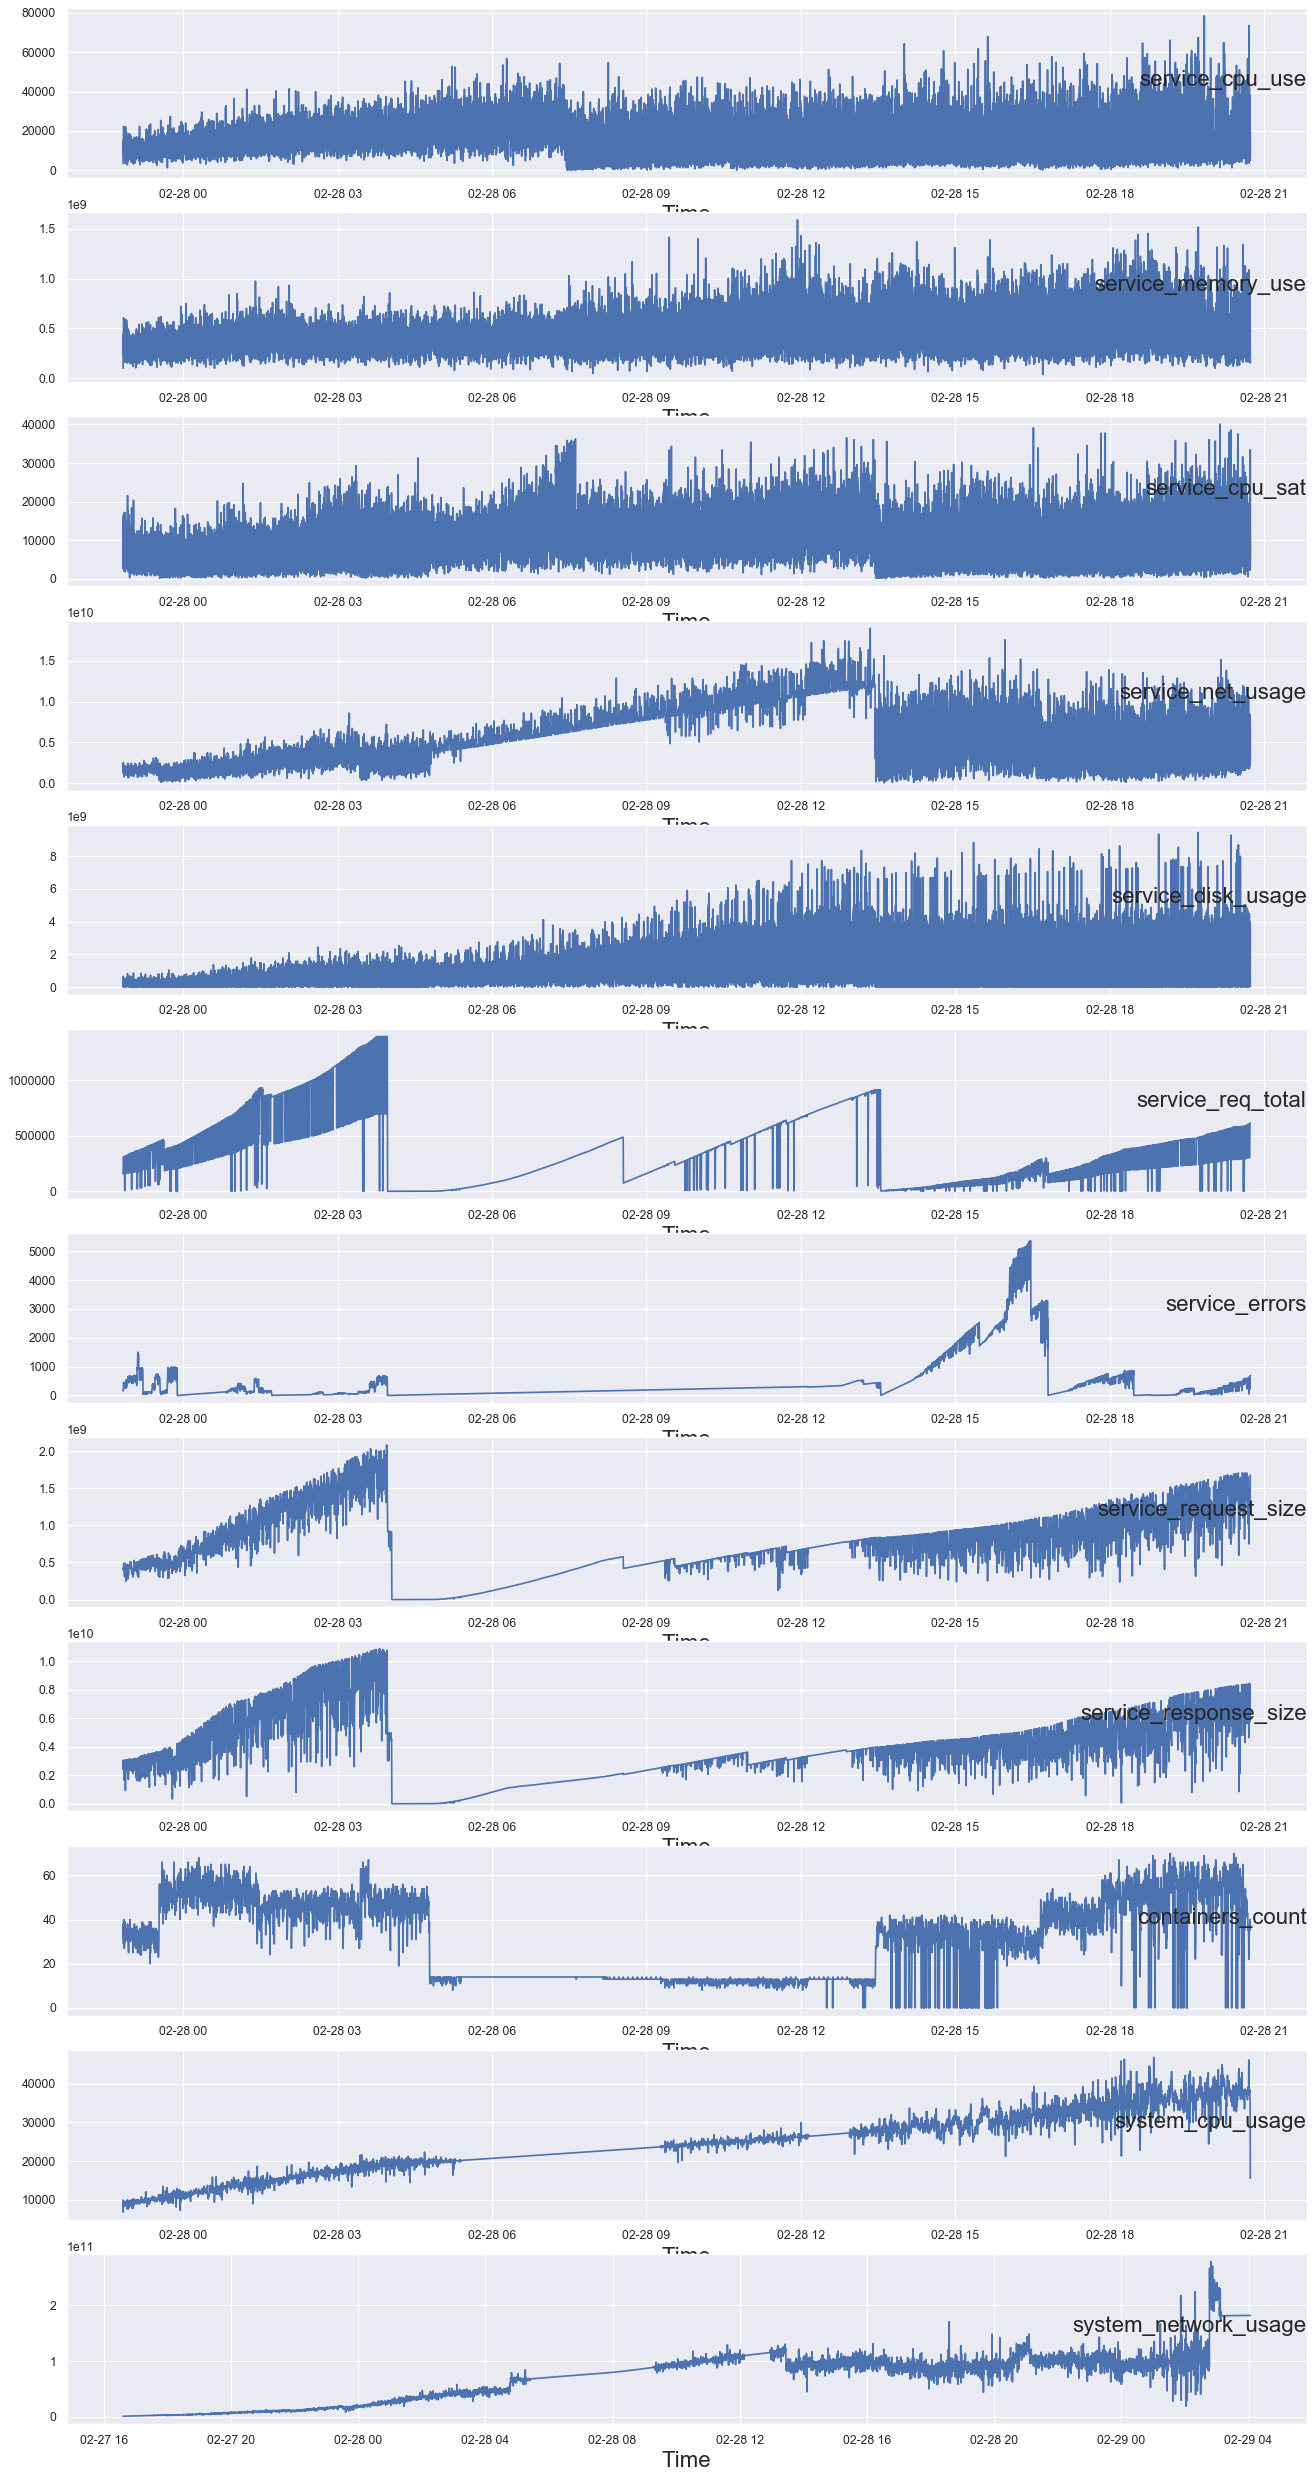

In [429]:
# merging feature columns

rows = len(features)
i = 1

plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')

for feature in features:
    print("Processing metric: %", feature)
    feature_series = extractMetricSeries(data_df, feature)
    #feature_series = resample(feature_series)    
    #feature_series = diff_series(feature_series)      # Taking the difference   
    if i == 1:
        features_df = pd.DataFrame(feature_series)
    else:
        features_df = merge(features_df, feature_series)
    plt.subplot(rows, 1, i)
    plt.plot(feature_series)
    plt.title(feature, y=0.5, loc='right', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    i += 1
    

features_df.sort_index()    
plt.show()    
    

In [430]:
features_df.shape

(78845, 12)

## Features transformation

In [431]:
# Rate in change
 
if FEATURES_RATE:    
    features_df = features_df.pct_change(fill_method='ffill', freq=rate_time_window)  # take percent chagne rate
    features_df = features_df[skip:]
elif FEATURES_DIFF:
    features_df = features_df.diff()      # Taking the difference 
    features_df = features_df[1:]

features_df.sort_index()
features_df.shape

(78845, 12)

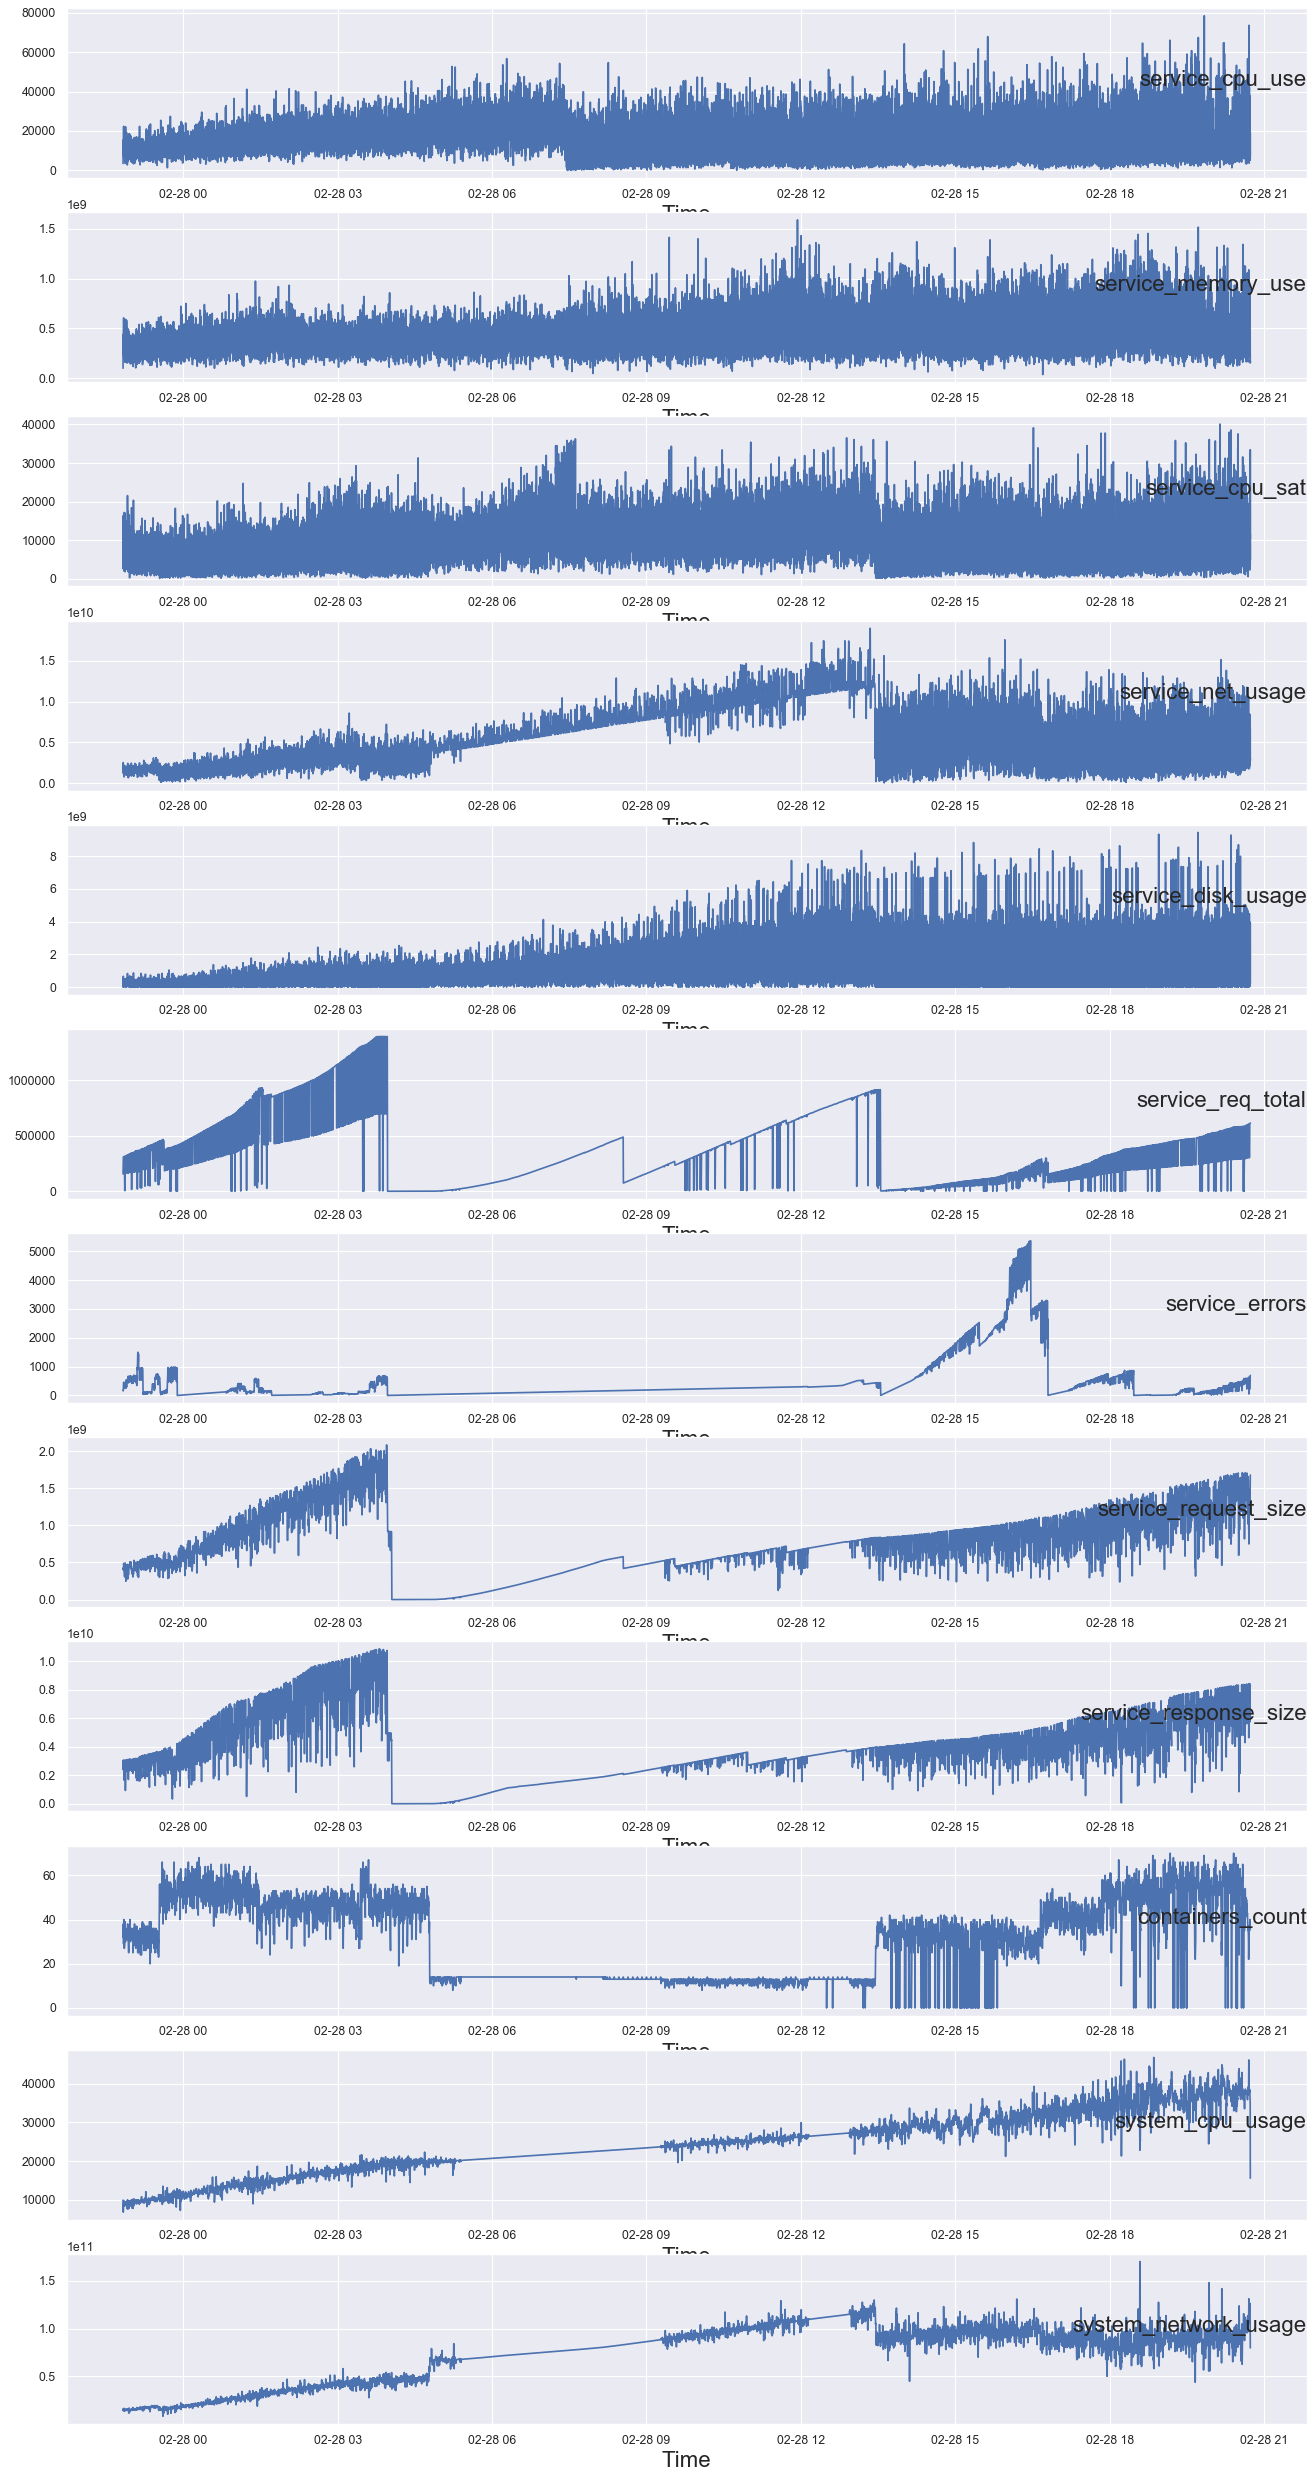

In [432]:
rows = len(features)
i = 1
plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')

for feature in features:
    feature_series = features_df[feature]
    plt.subplot(rows, 1, i)
    plt.plot(feature_series)
    plt.title(feature, y=0.5, loc='right', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    i += 1
     
plt.show()


In [433]:
# drop system_net_sat and system_disk_sat and system_disk_io
#metrics_df = metrics_df.drop('system_net_sat', 1)
#metrics_df = metrics_df.drop('system_disk_sat', 1)
#metrics_df = metrics_df.drop('system_disk_io', 1)

features_df.head(10)

,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,system_network_usage
date,,,,,,,,,,,,
2020-02-27 22:49:53,3504.83,98608742.40,5527.74,1500021423.46,135464140.80,156250.00,175.00,406144648.00,3032623081.00,32.00,9874.43,14773643788.28
2020-02-27 22:49:54,5742.95,204218845.87,6184.58,1473479090.82,152757043.20,166405.33,173.87,407529514.40,2989500183.60,32.00,9874.43,14883229834.87
2020-02-27 22:49:55,7981.07,309828949.33,5391.36,1446936758.17,122229145.60,176560.67,172.73,408914380.80,2946377286.20,32.00,9874.43,14992815881.47
2020-02-27 22:49:56,10242.46,409144320.00,5525.05,1420394425.53,91701248.00,186716.00,171.60,410299247.20,2903254388.80,32.00,9874.43,15173565432.11
2020-02-27 22:49:57,11901.57,389185308.44,5984.62,1382586121.89,85592064.00,196871.33,170.47,411684113.60,2860131491.40,32.00,9874.43,15354314982.76
2020-02-27 22:49:58,10968.80,314422840.89,6993.10,1376886432.08,66150400.00,207026.67,169.33,413068980.00,2817008594.00,32.00,9874.43,15435313232.53
2020-02-27 22:49:59,10126.12,308726715.73,8053.32,1395324196.00,60506112.00,217182.00,168.20,414453846.40,2773885696.60,32.00,9610.19,15517528854.98
2020-02-27 22:50:00,11627.06,357239785.24,9113.54,1477144877.03,90189824.00,227337.33,167.07,415838712.80,2730762799.20,32.00,9345.94,15599744477.42
2020-02-27 22:50:01,11425.09,395176527.64,10193.59,1531440135.40,86298233.90,237492.67,165.93,417223579.20,2687639901.80,32.00,9081.70,15681960099.86


In [434]:
# check any null
features_df.isnull().sum() * 100 / features_df.shape[0]

service_cpu_use         0.00
service_memory_use      0.00
service_cpu_sat         0.00
service_net_usage       0.00
service_disk_usage      0.00
service_req_total       0.00
service_errors          0.00
service_request_size    0.00
service_response_size   0.00
containers_count        0.00
system_cpu_usage        0.00
system_network_usage    0.00
dtype: float64

# Scale down the features

In [435]:
features_df.service_cpu_use = features_df.service_cpu_use / ( 60 * 60)
features_df.service_memory_use = features_df.service_memory_use / (1024 * 1024 * 1024)
features_df.service_cpu_sat = features_df.service_cpu_sat / ( 60 * 60 )
features_df.service_net_usage = features_df.service_net_usage / (1024 * 1024 * 1024)
features_df.service_disk_usage = features_df.service_disk_usage / (1024 * 1024 * 1024)
features_df.service_req_total = features_df.service_req_total / (1000000)
features_df.service_errors = features_df.service_errors / (1000)
features_df.service_request_size = features_df.service_request_size / (1024 * 1024 * 1024)
features_df.service_response_size = features_df.service_response_size / (1024 * 1024 * 1024)
features_df.containers_count = features_df.containers_count / (10)
features_df.system_cpu_usage = features_df.system_cpu_usage / ( 60 * 60)
features_df.system_network_usage = features_df.system_network_usage / (1024 * 1024 * 1024)

features_df.head()

,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,system_network_usage
date,,,,,,,,,,,,
2020-02-27 22:49:53,0.97,0.09,1.54,1.40,0.13,0.16,0.17,0.38,2.82,3.20,2.74,13.76
2020-02-27 22:49:54,1.60,0.19,1.72,1.37,0.14,0.17,0.17,0.38,2.78,3.20,2.74,13.86
2020-02-27 22:49:55,2.22,0.29,1.50,1.35,0.11,0.18,0.17,0.38,2.74,3.20,2.74,13.96
2020-02-27 22:49:56,2.85,0.38,1.53,1.32,0.09,0.19,0.17,0.38,2.70,3.20,2.74,14.13
2020-02-27 22:49:57,3.31,0.36,1.66,1.29,0.08,0.20,0.17,0.38,2.66,3.20,2.74,14.30


In [436]:
if False:
    from sklearn.preprocessing import MinMaxScaler

    min_date = features_df.index.min()
    features_num = features_df.shape[0]
    columns = features_df.columns.values

    date_idx = pd.date_range(min_date, periods=features_num, freq='S')

    features_scaler = MinMaxScaler(feature_range=(-1,1))
    features_values = features_scaler.fit_transform(features_df)

    features_df = pd.DataFrame(features_values, index=date_idx, columns=columns)

    features_df.head(5)

# Concatenate features and target dataframes

In [437]:
#all_data = pd.concat([features_df, target_df], axis=1)

all_data = merge(features_df, target_df)
all_data = all_data[all_data['service_ltcy_200'].notna()]

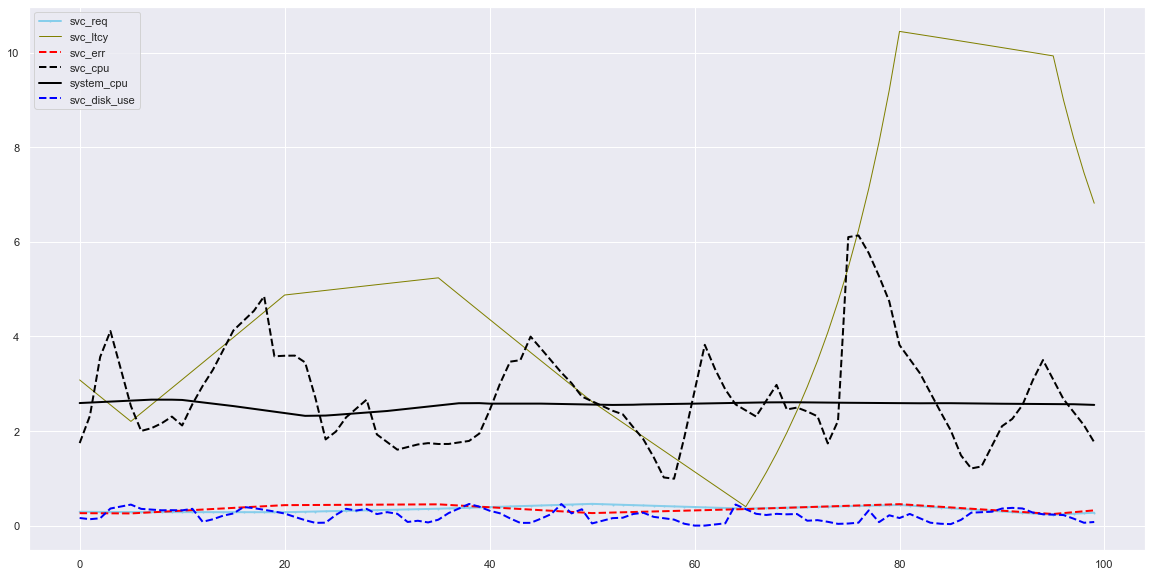

In [443]:
plt_df = pd.DataFrame()

xlen=100
rng = [i for i in range(0,xlen)]
rng_df = pd.Series(rng)
plt_df['seq'] = rng_df
plt_df['svc_req'] = pd.Series(all_data[xlen:].service_request_size.values)
plt_df['svc_ltcy'] = pd.Series(all_data[xlen:].service_ltcy_200.values)
plt_df['svc_cpu'] = pd.Series(all_data[xlen:].service_cpu_use.values)
plt_df['svc_err'] = pd.Series(all_data[xlen:].service_errors.values)
plt_df['system_cpu'] = pd.Series(all_data[xlen:].system_cpu_usage.values)
plt_df['svc_disk_use'] = pd.Series(all_data[xlen:].service_disk_usage.values)


plt.figure(figsize=(20,10))
plt.plot( 'seq', 'svc_req', data=plt_df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'seq', 'svc_ltcy', data=plt_df, marker='', color='olive', linewidth=1)
plt.plot( 'seq', 'svc_err', data=plt_df, marker='', color='red', linewidth=2, linestyle='dashed')
plt.plot( 'seq', 'svc_cpu', data=plt_df, marker='', color='black', linewidth=2, linestyle='dashed')
plt.plot( 'seq', 'system_cpu', data=plt_df, marker='', color='black', linewidth=2)
plt.plot( 'seq', 'svc_disk_use', data=plt_df, marker='', color='blue', linewidth=2, linestyle='dashed')
plt.legend()


# Add Data

Let's a signal to indicate day and time of the the metric 

In [439]:
samples = all_data.shape[0]
samples

78845

In [440]:
#metrics_df['Hour'] = metrics_df.index.hour 
#all_data['time'] = (all_data.index.values - all_data.index.values.astype('datetime64[D]'))/np.timedelta64(1,'s')
all_data.head(80)


,service_cpu_use,service_memory_use,service_cpu_sat,service_net_usage,service_disk_usage,service_req_total,service_errors,service_request_size,service_response_size,containers_count,system_cpu_usage,system_network_usage,service_ltcy_200
date,,,,,,,,,,,,,
2020-02-27 22:49:53,0.97,0.09,1.54,1.40,0.13,0.16,0.17,0.38,2.82,3.20,2.74,13.76,2.53
2020-02-27 22:49:54,1.60,0.19,1.72,1.37,0.14,0.17,0.17,0.38,2.78,3.20,2.74,13.86,2.70
2020-02-27 22:49:55,2.22,0.29,1.50,1.35,0.11,0.18,0.17,0.38,2.74,3.20,2.74,13.96,2.87
2020-02-27 22:49:56,2.85,0.38,1.53,1.32,0.09,0.19,0.17,0.38,2.70,3.20,2.74,14.13,3.04
2020-02-27 22:49:57,3.31,0.36,1.66,1.29,0.08,0.20,0.17,0.38,2.66,3.20,2.74,14.30,3.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-27 22:51:08,3.05,0.35,3.07,1.31,0.38,0.31,0.26,0.31,1.54,2.70,2.64,14.84,4.80
2020-02-27 22:51:09,2.93,0.31,2.78,1.37,0.38,0.30,0.26,0.31,1.57,2.70,2.65,14.98,4.80
2020-02-27 22:51:10,2.89,0.28,2.34,1.44,0.24,0.29,0.26,0.31,1.60,2.70,2.66,15.13,4.81


## Save Metrics TimeSeries Data

In [441]:
if SAVE:
    all_data.sort_index()
    all_data.to_csv(output_dir + output_file)